In [48]:
import random
import pickle
import itertools

import numpy as np 
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [49]:
df = pd.read_csv("mitbih_train.csv", header=None)
df2 = pd.read_csv("mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [50]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [52]:
df[187].value_counts()

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64

In [53]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [54]:
df[187]=df[187].astype(int)
equilibre=df[187].value_counts()
print(equilibre)

187
0    90589
4     8039
2     7236
1     2779
3      803
Name: count, dtype: int64


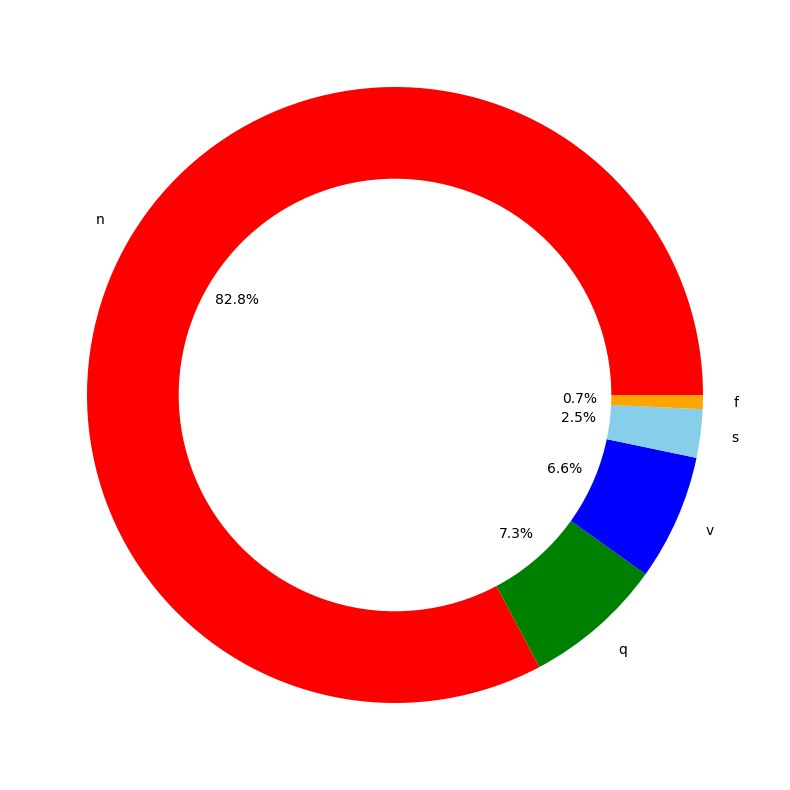

In [55]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [56]:
del df
del df2
del M

# Visual Input

In [57]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

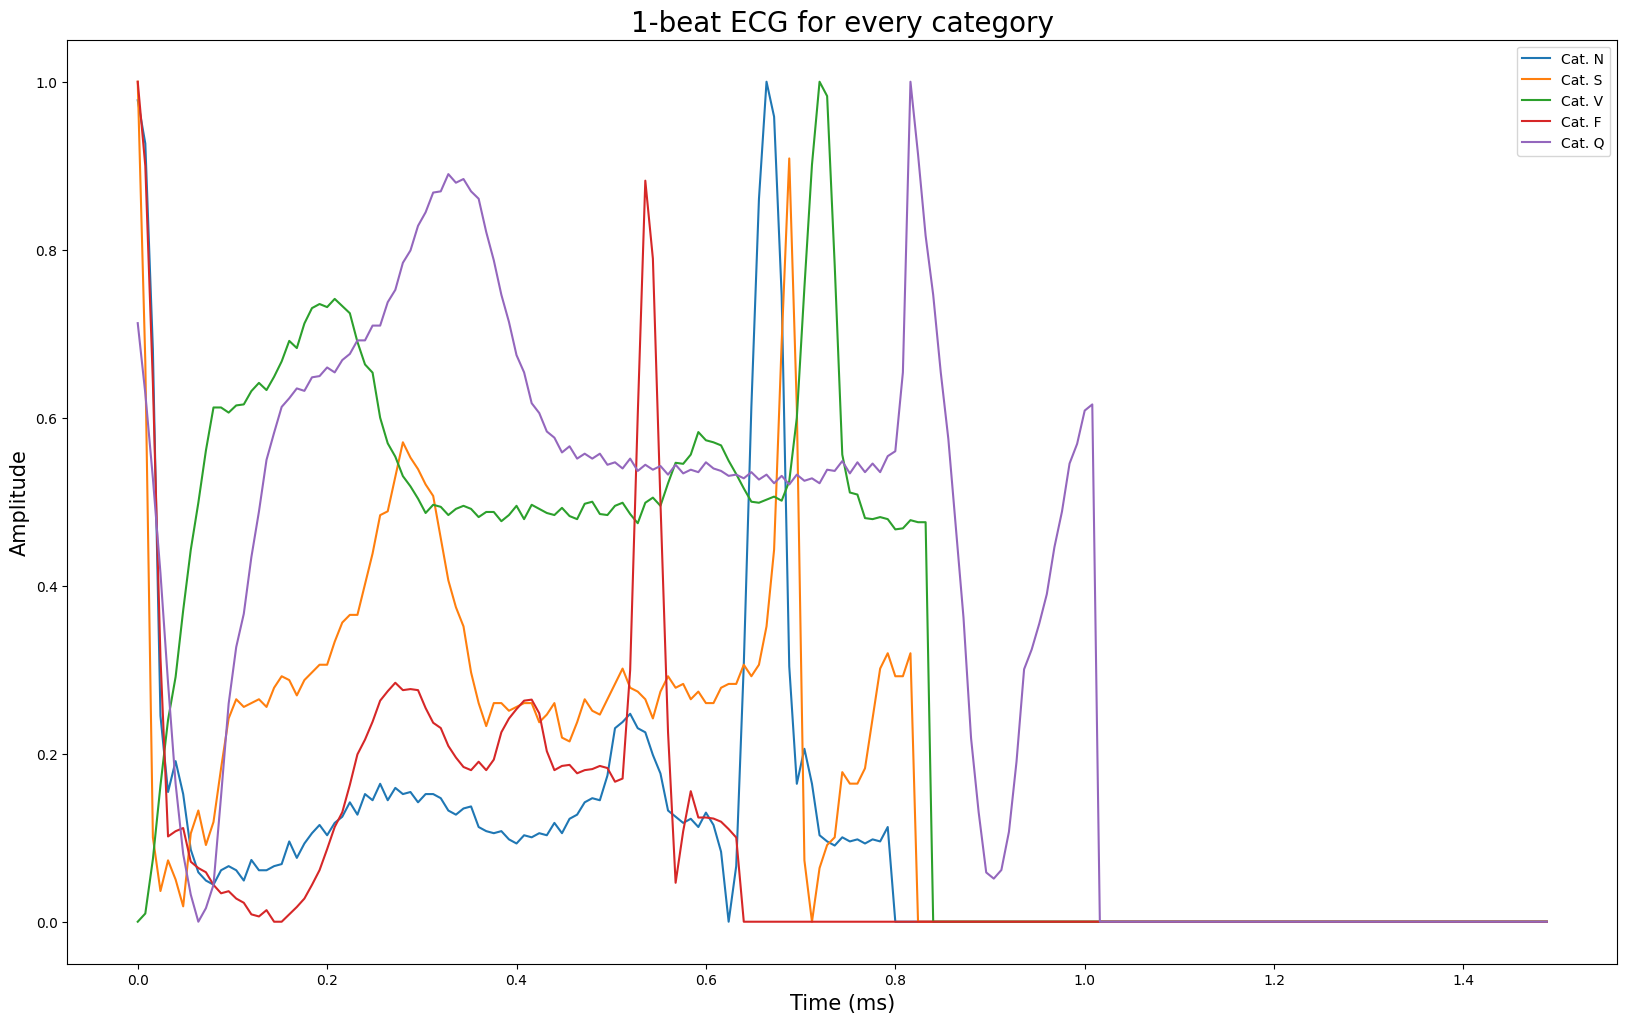

In [58]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

In [59]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

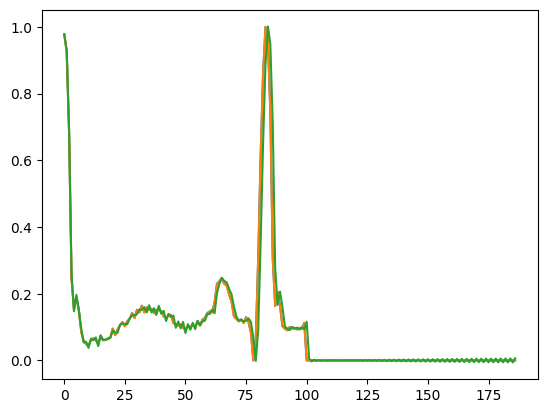

In [60]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [61]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

# Split

In [ ]:
# Train-Test Split
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [63]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y


In [64]:
# Reshape Data
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [65]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [66]:
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

In [67]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [68]:
# Define Model
K.clear_session()
inp = Input(shape=(187, 1))
C = Conv1D(32, 5, strides=1)(inp)

for _ in range(4):
    C1 = Conv1D(32, 5, padding='same', activation="relu")(C)
    C2 = Conv1D(32, 5, padding='same')(C1)
    C = Activation("relu")(Add()([C2, C]))
    C = MaxPooling1D(5, strides=2)(C)

F = Flatten()(C)
D = Dense(32, activation="relu")(F)
D = Dense(32, activation="relu")(D)
D = Dense(5, activation="softmax")(D)

model = Model(inputs=inp, outputs=D)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 183, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 183, 32)   │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 183, 32)   │      5,152 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 183, 32)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 183, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 90, 32)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 90, 32)    │      5,152 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 90, 32)    │      5,152 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 90, 32)    │          0 │ conv1d_4[0][0],   │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 32)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 43, 32)    │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 43, 32)    │      5,152 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 43, 32)    │      5,152 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 43, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 43, 32)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 20, 32)    │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 20, 32)    │      5,152 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 20, 32)    │      5,152 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 32)    │          0 │ conv1d_8[0][0], 

 Total params: 50,853 (198.64 KB)

 Trainable params: 50,853 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
import math
# Learning Rate Scheduler
def exp_decay(epoch):
    return 0.001 * math.exp(-0.75 * (X_train.shape[0] // (10000 * 500)))

lrate = LearningRateScheduler(exp_decay)

In [70]:
# Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=500, validation_data=(X_test, y_test), callbacks=[lrate])


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8384 - loss: 0.5630 - val_accuracy: 0.6455 - val_loss: 1.1633 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9571 - loss: 0.1523 - val_accuracy: 0.8395 - val_loss: 0.5541 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9711 - loss: 0.1040 - val_accuracy: 0.8725 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9757 - loss: 0.0867 - val_accuracy: 0.8788 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9780 - loss: 0.0742 - val_accuracy: 0.9068 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9807 - loss: 0.0652 - val_accuracy: 0.8945 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9832 - 

In [71]:
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("Ranking-based average precision: {:.3f}".format(label_ranking_average_precision_score(y_test, y_pred)))
print("Ranking loss: {:.3f}".format(label_ranking_loss(y_test, y_pred)))
print("Coverage error: {:.3f}".format(coverage_error(y_test, y_pred)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       800
           1       1.00      0.83      0.91       800
           2       0.97      0.95      0.96       800
           3       0.99      0.93      0.96       800
           4       1.00      0.99      1.00       800

    accuracy                           0.94      4000
   macro avg       0.95      0.94      0.94      4000
weighted avg       0.95      0.94      0.94      4000

Ranking-based average precision: 0.969
Ranking loss: 0.018
Coverage error: 1.071


In [72]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       800
           1       1.00      0.83      0.91       800
           2       0.97      0.95      0.96       800
           3       0.99      0.93      0.96       800
           4       1.00      0.99      1.00       800

    accuracy                           0.94      4000
   macro avg       0.95      0.94      0.94      4000
weighted avg       0.95      0.94      0.94      4000



In [73]:
print("Ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test, y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test, y_pred)))
print("Coverage error : {:.3f}".format(coverage_error(y_test, y_pred)))


Ranking-based average precision : 0.969
Ranking loss : 0.018
Coverage error : 1.071


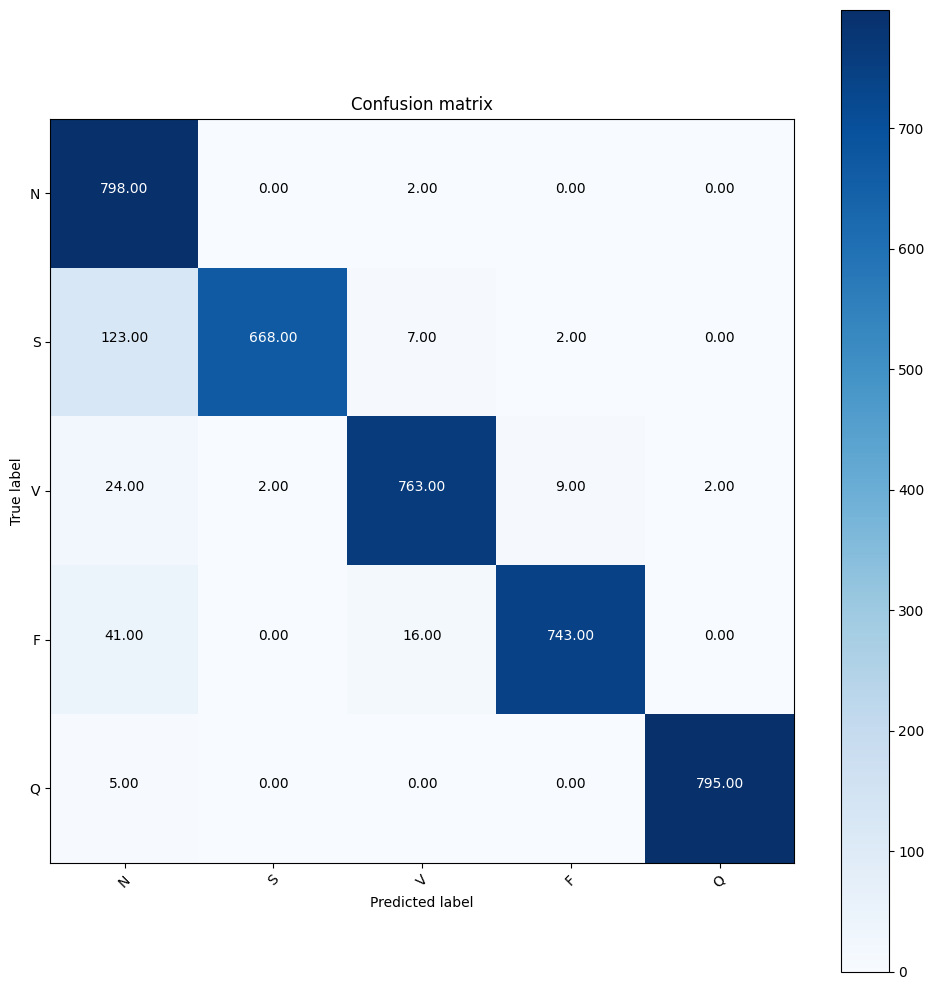

In [74]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cm, ['N', 'S', 'V', 'F', 'Q'])
